# Neural Network for CAP Classification
### Author: Apurva R Umredkar


In [1]:
#Libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset = loadmat("/content/drive/MyDrive/CAP Research Data/eeg _signals_1d_balanced_9306.mat")['val']
#dataset= np.load("/content/drive/MyDrive/CAP Research Data/eeg_data_21984_balanced.npy")
N= dataset.shape[0]
mmscaler= MinMaxScaler()

signals= dataset[:,:1024]
signals_dft= np.fft.fft(signals)
dft_abs = np.abs(signals_dft)
dft_ang = np.angle(signals_dft)

inputs = mmscaler.fit_transform(dft_abs[:,1:513]).reshape((N,512,1))
targets= dataset[:,1024]

from sklearn.utils import shuffle
X, Y= shuffle(inputs, targets, random_state= None)

skfold = StratifiedKFold(n_splits=5)

In [3]:
#Architecture of the model
def inception_module(layer, f1, f2, f3, f4):
  conv1 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  conv2 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  conv3 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  maxp = MaxPool1D(pool_size=3, strides= 1, padding= 'same')(layer)

  conv2 = Conv1D(f2, 3, activation= 'relu', padding= 'same')(conv2)
  conv3 = Conv1D(f3, 5, activation= 'relu', padding= 'same')(conv3)
  conv4 = Conv1D(f4, 1, activation= 'relu', padding= 'same')(maxp)

  return Concatenate()([conv1, conv2, conv3, conv4])

input_signal= Input(shape=(512,1))

incept= inception_module(input_signal, 32,64,128,32)
conv= Conv1D(192, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(128, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(128, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,16,32,64,16)
conv= Conv1D(96, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(64, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(64, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,8,16,32,8)
conv= Conv1D(48, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(32, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(32, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,4,8,16,4)
conv= Conv1D(24, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(16, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(16, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,2,4,8,2)
conv= Conv1D(12, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(8, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(8, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

flat = Flatten()(gru)
output= Dense(2, activation='softmax')(flat)

if 'model' in globals() or 'model' in locals(): del model

model= keras.Model(inputs = input_signal, outputs = output)
model.summary()
init_weights = model.get_weights()
#plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 512, 1)       0           input_1[0][0]                    
______________________________________________________________________________________________

Training for Fold #1
Epoch 1/2500
94/94 [==============================] - 53s 121ms/step - loss: 0.6926 - accuracy: 0.5228 - val_loss: 0.6860 - val_accuracy: 0.5212
Epoch 2/2500
94/94 [==============================] - 8s 89ms/step - loss: 0.6776 - accuracy: 0.5923 - val_loss: 0.6675 - val_accuracy: 0.6206
Epoch 3/2500
94/94 [==============================] - 8s 89ms/step - loss: 0.6585 - accuracy: 0.6272 - val_loss: 0.6476 - val_accuracy: 0.6031
Epoch 4/2500
94/94 [==============================] - 8s 89ms/step - loss: 0.6320 - accuracy: 0.6601 - val_loss: 0.6264 - val_accuracy: 0.6608
Epoch 5/2500
94/94 [==============================] - 8s 89ms/step - loss: 0.6117 - accuracy: 0.6783 - val_loss: 0.6026 - val_accuracy: 0.6897
Epoch 6/2500
94/94 [==============================] - 8s 90ms/step - loss: 0.6019 - accuracy: 0.6806 - val_loss: 0.5981 - val_accuracy: 0.6891
Epoch 7/2500
94/94 [==============================] - 8s 90ms/step - loss: 0.5952 - accuracy: 0.6860 - val_loss: 0.5896

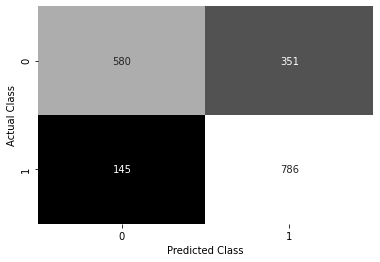

Accuracy Metrics:                 0
count  113.000000
mean     0.723877
std      0.030947
min      0.522754
25%      0.715869
50%      0.728799
75%      0.741730
max      0.761545

Loss Metrics:                 0
count  113.000000
mean     0.542776
std      0.033489
min      0.497509
25%      0.521430
50%      0.538998
75%      0.553825
max      0.692634

Val. Accuracy Metrics:                 0
count  113.000000
mean     0.717224
std      0.025747
min      0.521155
25%      0.717932
50%      0.723976
75%      0.725991
max      0.736064

Val. Loss Metrics:                 0
count  113.000000
mean     0.558866
std      0.023601
min      0.540935
25%      0.546028
50%      0.551442
75%      0.559522
max      0.686043


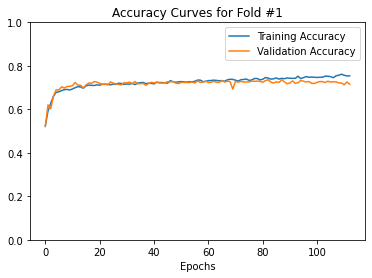

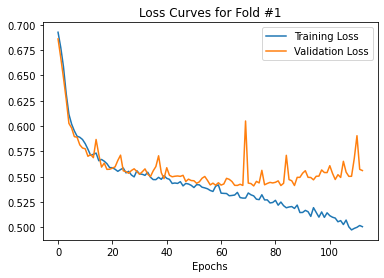

Training for Fold #2
Epoch 1/2500
94/94 [==============================] - 19s 119ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4795
Epoch 2/2500
94/94 [==============================] - 9s 93ms/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4795
Epoch 3/2500
94/94 [==============================] - 9s 93ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4795
Epoch 4/2500
94/94 [==============================] - 9s 92ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4795
Epoch 5/2500
94/94 [==============================] - 9s 92ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6934 - val_accuracy: 0.4795
Epoch 6/2500
94/94 [==============================] - 9s 92ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6934 - val_accuracy: 0.4795
Epoch 7/2500
94/94 [==============================] - 9s 93ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6934

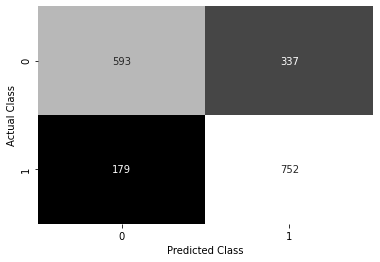

Accuracy Metrics:                 0
count  139.000000
mean     0.706924
std      0.062563
min      0.494124
25%      0.702065
50%      0.728173
75%      0.740094
max      0.763264

Loss Metrics:                 0
count  139.000000
mean     0.553816
std      0.054516
min      0.484895
25%      0.520797
50%      0.535990
75%      0.567522
max      0.693173

Val. Accuracy Metrics:                 0
count  139.000000
mean     0.694039
std      0.061242
min      0.479516
25%      0.703492
50%      0.715917
75%      0.721289
max      0.728677

Val. Loss Metrics:                 0
count  139.000000
mean     0.573607
std      0.042184
min      0.541921
25%      0.548023
50%      0.556020
75%      0.582623
max      0.693436


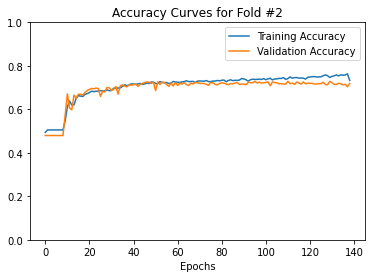

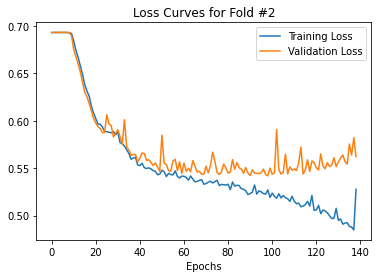

Training for Fold #3
Epoch 1/2500
94/94 [==============================] - 18s 110ms/step - loss: 0.6931 - accuracy: 0.5044 - val_loss: 0.6932 - val_accuracy: 0.4795
Epoch 2/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6932 - val_accuracy: 0.4795
Epoch 3/2500
94/94 [==============================] - 9s 95ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4795
Epoch 4/2500
94/94 [==============================] - 9s 95ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4795
Epoch 5/2500
94/94 [==============================] - 9s 95ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4795
Epoch 6/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6930 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4795
Epoch 7/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6929 - accuracy: 0.5052 - val_loss: 0.6932

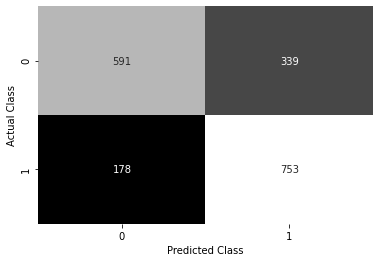

Accuracy Metrics:                 0
count  134.000000
mean     0.707800
std      0.064032
min      0.504365
25%      0.716336
50%      0.728257
75%      0.738373
max      0.756548

Loss Metrics:                 0
count  134.000000
mean     0.555047
std      0.052409
min      0.497284
25%      0.523724
50%      0.539641
75%      0.559521
max      0.693148

Val. Accuracy Metrics:                 0
count  134.000000
mean     0.699483
std      0.066195
min      0.479516
25%      0.711887
50%      0.724312
75%      0.728677
max      0.736736

Val. Loss Metrics:                 0
count  134.000000
mean     0.568496
std      0.045090
min      0.537110
25%      0.543262
50%      0.550083
75%      0.563759
max      0.693313


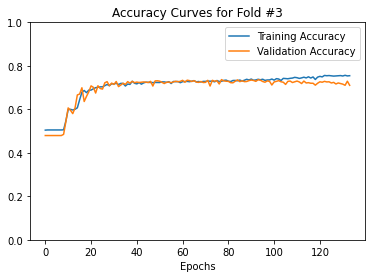

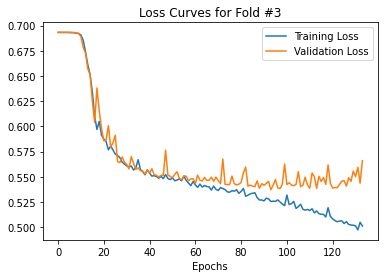

Training for Fold #4
Epoch 1/2500
94/94 [==============================] - 18s 110ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6933 - val_accuracy: 0.4795
Epoch 2/2500
94/94 [==============================] - 9s 93ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6935 - val_accuracy: 0.4795
Epoch 3/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6934 - val_accuracy: 0.4795
Epoch 4/2500
94/94 [==============================] - 9s 93ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6934 - val_accuracy: 0.4795
Epoch 5/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6934 - val_accuracy: 0.4795
Epoch 6/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6934 - val_accuracy: 0.4795
Epoch 7/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6934

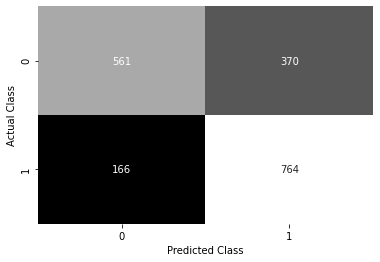

Accuracy Metrics:                 0
count  124.000000
mean     0.693777
std      0.084877
min      0.505037
25%      0.707774
50%      0.729097
75%      0.742948
max      0.763936

Loss Metrics:                 0
count  124.000000
mean     0.563450
std      0.064796
min      0.488095
25%      0.522443
50%      0.539034
75%      0.570007
max      0.693136

Val. Accuracy Metrics:                 0
count  124.000000
mean     0.676515
std      0.087337
min      0.479516
25%      0.696608
50%      0.716588
75%      0.723976
max      0.734721

Val. Loss Metrics:                 0
count  124.000000
mean     0.584501
std      0.053368
min      0.541129
25%      0.549624
50%      0.559444
75%      0.585650
max      0.693543


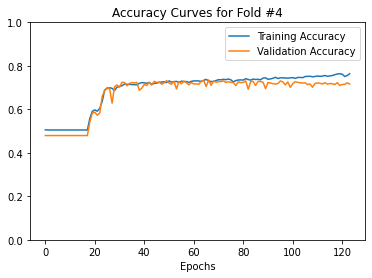

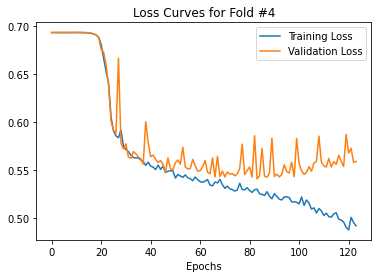

Training for Fold #5
Epoch 1/2500
94/94 [==============================] - 18s 110ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4929
Epoch 2/2500
94/94 [==============================] - 9s 92ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4929
Epoch 3/2500
94/94 [==============================] - 9s 93ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4929
Epoch 4/2500
94/94 [==============================] - 9s 93ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4929
Epoch 5/2500
94/94 [==============================] - 9s 93ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4929
Epoch 6/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.4929
Epoch 7/2500
94/94 [==============================] - 9s 94ms/step - loss: 0.6931 - accuracy: 0.5017 - val_loss: 0.6932

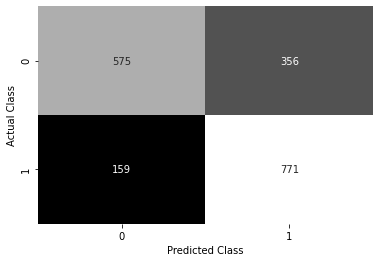

Accuracy Metrics:                 0
count  134.000000
mean     0.683271
std      0.090517
min      0.501679
25%      0.692117
50%      0.725067
75%      0.738373
max      0.758059

Loss Metrics:                 0
count  134.000000
mean     0.571724
std      0.065478
min      0.500973
25%      0.527105
50%      0.545095
75%      0.585115
max      0.693167

Val. Accuracy Metrics:                 0
count  134.000000
mean     0.662991
std      0.083988
min      0.492948
25%      0.680994
50%      0.706514
75%      0.711887
max      0.721289

Val. Loss Metrics:                 0
count  134.000000
mean     0.593417
std      0.052981
min      0.551263
25%      0.558237
50%      0.565226
75%      0.596387
max      0.693222


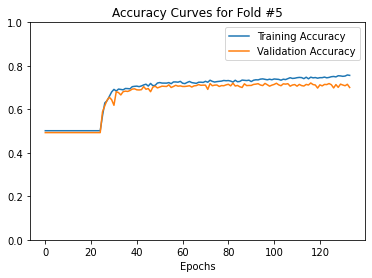

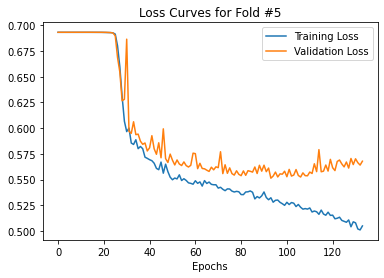

In [4]:
#Hyperparameters
epochs= 2500
batch_size= 64
validation_split= 0.2
lr = 1e-4
early_stop= keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose =1, patience=40, restore_best_weights=True)
opt= keras.optimizers.Adam(learning_rate=lr)

total_confmat = np.zeros((2,2))
fold_num=1
total_history = []
total_results = []

start = time.time()
for train, test in skfold.split(X,Y):
  X_train, X_test = X[train], X[test]
  Y_train =  to_categorical(Y[train])                                                        
  Y_test =  to_categorical(Y[test])

  keras.backend.clear_session()
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics=['accuracy'])
  model.set_weights(init_weights)
  model.reset_states()

  print(f'Training for Fold #{fold_num}')
  history = model.fit(X_train, Y_train, validation_split= validation_split, epochs =epochs, batch_size=batch_size, verbose =1, callbacks=[early_stop])
  res = model.evaluate(X_test, Y_test)

  total_history.append(history)
  total_results.append(res)

  #Prediction
  Ypred = model.predict(X_test)
  Ypred = np.round(Ypred)
  print(classification_report(Y_test,Ypred))

  #Confusion Matrix
  confmat = confusion_matrix(Y_test.argmax(axis=1),Ypred.argmax(axis=1))
  confmat_heatmap = sns.heatmap(confmat, annot=True, fmt='', cmap='gray', cbar = False)
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.title('')
  plt.show()

  total_confmat+= confmat

  #Stats of Metrics
  acc = pd.DataFrame(history.history['accuracy'])
  loss  = pd.DataFrame(history.history['loss'])
  valacc = pd.DataFrame(history.history['val_accuracy'])
  valloss = pd.DataFrame(history.history['val_loss'])
  print(f'Accuracy Metrics: {acc.describe()}\n')
  print(f'Loss Metrics: {loss.describe()}\n')
  print(f'Val. Accuracy Metrics: {valacc.describe()}\n')
  print(f'Val. Loss Metrics: {valloss.describe()}')

  #Plots
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Training Accuracy','Validation Accuracy'])
  plt.xlabel('Epochs')
  plt.title(label=f'Accuracy Curves for Fold #{fold_num}')
  plt.ylim(0,1)
  plt.show()
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Training Loss','Validation Loss'])
  plt.xlabel('Epochs')
  plt.title(label=f'Loss Curves for Fold #{fold_num}')
  plt.show()

  fold_num+=1
  
end = time.time()

In [5]:
np.mean(np.array(total_results)[:,1]), np.std(np.array(total_results)[:,1])

(0.7227583408355713, 0.006850733505301851)

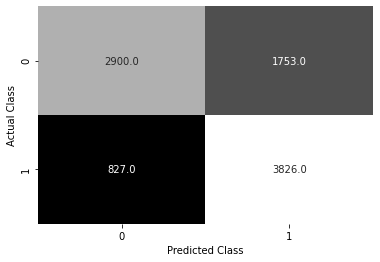

In [6]:
  confmat_heatmap = sns.heatmap(total_confmat, annot=True, fmt='', cmap='gray', cbar = False)
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.title('')
  plt.show()

In [7]:
total_results

[[0.5302784442901611, 0.733619749546051],
 [0.5476796627044678, 0.7227297425270081],
 [0.5485305786132812, 0.7221923470497131],
 [0.5538897514343262, 0.711982786655426],
 [0.5452908873558044, 0.7232670783996582]]